<a href="https://colab.research.google.com/github/uday-routhu/week7/blob/master/Neural_Networks_Core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks (Core)

- author: Udayakumar Routhu

Required Task:
1. Be sure to perform a train test split on the train.csv so you can evaluate your models.
2. Create and evaluate 3 iterations of a deep learning model to predict housing prices using the techniques you have learned to optimize your model's performance.
3. Be sure to include some form of regularization with at least one model.
Select your best model!

### Import Libraries

In [95]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns


# Set global scikit-learn configuration
from sklearn import set_config
# Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

In [96]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [97]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
# Load in the dataset from url
fpath = "/content/drive/MyDrive/CodingDojo/03-AdvancedML/Week11/Data/train.csv"
df = pd.read_csv(fpath, index_col=0)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [99]:
# Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 1460 rows, and 80 columns.
The rows represent 1460 observations, and the columns represent 79 features and 1 target variable.


## Prepare the Data

In [100]:
# Display the info for the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [101]:
df.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [102]:
# Drop missings
#df = df.dropna(axis=1)

In [103]:
df.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [104]:
# check for duplicates
df.duplicated().sum()

0

In [105]:
# Save X data
X = df.drop(columns = 'SalePrice')
# Encode our target
y = df['SalePrice']

In [106]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Train/Test Split

In [107]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [108]:
# Check class balance
y_train.value_counts(normalize=True)

140000    0.010959
135000    0.010046
155000    0.010046
110000    0.009132
190000    0.009132
            ...   
253000    0.000913
328900    0.000913
212900    0.000913
118964    0.000913
37900     0.000913
Name: SalePrice, Length: 549, dtype: float64

In [109]:
# create preprocessor
cat_select = make_column_selector(dtype_include='object')
num_select = make_column_selector(dtype_include='number')

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

num_tuple = ('num', scaler, num_select)
cat_tuple = ('cat', ohe, cat_select)

processor = ColumnTransformer([num_tuple, cat_tuple], remainder='passthrough')

In [118]:
from sklearn.impute import SimpleImputer
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)

OneHotEncoder Columns: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Numeric Columns: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', '

In [119]:
# process the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Model 1

In [120]:
# create and compile the model
model = keras.Sequential()
model.add(Dense(10, input_dim=X_train_processed.shape[1],
          activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

In [122]:
# Train the model and save the history
history = model.fit(X_train_processed, y_train, validation_split=0.2, epochs=10)

Epoch 1/10
28/28 [==============================] - 4s 28ms/step - loss: -74223.2500 - accuracy: 0.0000e+00 - val_loss: -189651.4375 - val_accuracy: 0.0000e+00
Epoch 2/10
28/28 [==============================] - 0s 10ms/step - loss: -390963.3750 - accuracy: 0.0000e+00 - val_loss: -622530.5000 - val_accuracy: 0.0000e+00
Epoch 3/10
28/28 [==============================] - 0s 9ms/step - loss: -966686.1250 - accuracy: 0.0000e+00 - val_loss: -1309658.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
28/28 [==============================] - 0s 11ms/step - loss: -1846765.8750 - accuracy: 0.0000e+00 - val_loss: -2324594.5000 - val_accuracy: 0.0000e+00
Epoch 5/10
28/28 [==============================] - 0s 10ms/step - loss: -3112724.5000 - accuracy: 0.0000e+00 - val_loss: -3770783.7500 - val_accuracy: 0.0000e+00
Epoch 6/10
28/28 [==============================] - 0s 12ms/step - loss: -4875261.0000 - accuracy: 0.0000e+00 - val_loss: -5735361.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
28/28 [===========

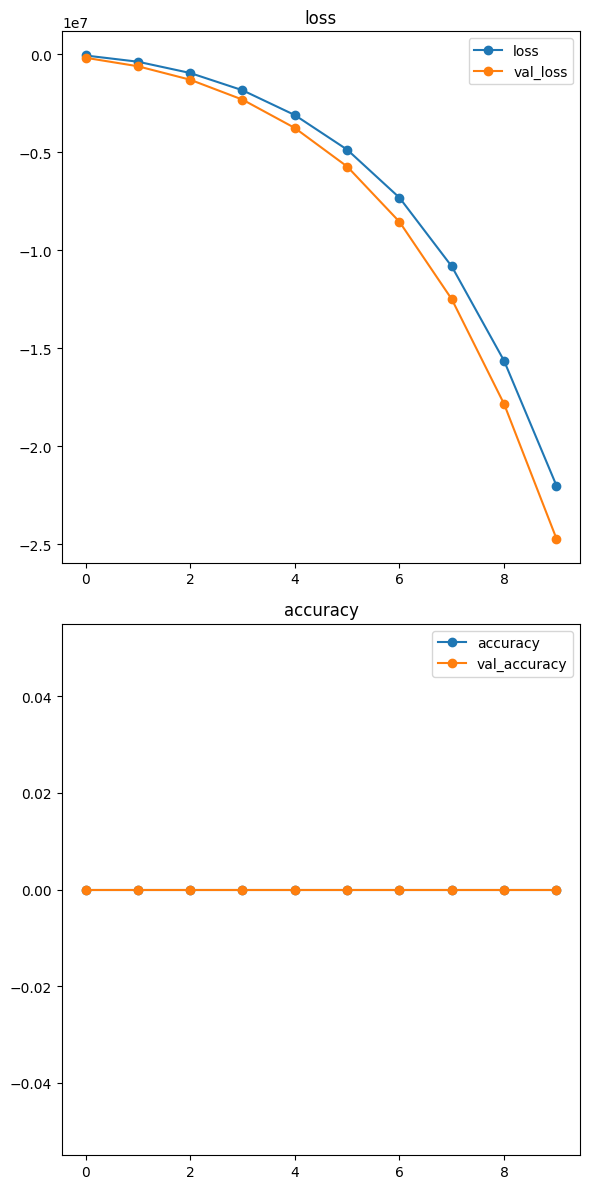

In [123]:
# Call the custom function
plot_history(history);

In [124]:
# Evaluate neural network with builtin evaluation
result = model.evaluate(X_test_processed, y_test,return_dict=True)
result

12/12 [==============================] - 0s 7ms/step - loss: -24975620.0000 - accuracy: 0.0000e+00


{'loss': -24975620.0, 'accuracy': 0.0}

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       0.0
     40000.0       0.00      0.00      0.00       1.0
     52500.0       0.00      0.00      0.00       1.0
     55000.0       0.00      0.00      0.00       1.0
     58500.0       0.00      0.00      0.00       1.0
     64500.0       0.00      0.00      0.00       1.0
     73000.0       0.00      0.00      0.00       1.0
     75500.0       0.00      0.00      0.00       1.0
     87000.0       0.00      0.00      0.00       1.0
     88000.0       0.00      0.00      0.00       1.0
     93000.0       0.00      0.00      0.00       1.0
     94500.0       0.00      0.00      0.00       1.0
     94750.0       0.00      0.00      0.00       1.0
     95000.0       0.00      0.00      0.00       1.0
     96500.0       0.00      0.00      0.00       2.0
     98000.0       0.00      0.00      0.00       1.0
     99900.0       0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

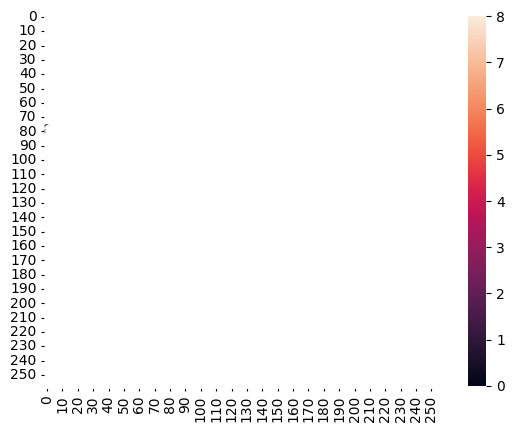

In [125]:
# evaluate the model with sklearn metrics
test_preds = model.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt ='g');

# Model 2: More Neurons

In [126]:
# create model
model2 = keras.Sequential()
model2.add(Dense(20, input_dim=X_train_processed.shape[1],
          activation = 'relu'))
model2.add(Dense(5, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

In [127]:
# train the model and save the history
history = model2.fit(X_train_processed, y_train,
          validation_split=(.2),
          epochs = 10)

Epoch 1/10
28/28 [==============================] - 4s 22ms/step - loss: -189169.0000 - accuracy: 0.0000e+00 - val_loss: -446142.0938 - val_accuracy: 0.0000e+00
Epoch 2/10
28/28 [==============================] - 0s 7ms/step - loss: -887868.5625 - accuracy: 0.0000e+00 - val_loss: -1379273.3750 - val_accuracy: 0.0000e+00
Epoch 3/10
28/28 [==============================] - 0s 10ms/step - loss: -2116917.5000 - accuracy: 0.0000e+00 - val_loss: -2806940.7500 - val_accuracy: 0.0000e+00
Epoch 4/10
28/28 [==============================] - 0s 6ms/step - loss: -3892377.2500 - accuracy: 0.0000e+00 - val_loss: -4868904.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
28/28 [==============================] - 0s 6ms/step - loss: -6452212.5000 - accuracy: 0.0000e+00 - val_loss: -7774279.5000 - val_accuracy: 0.0000e+00
Epoch 6/10
28/28 [==============================] - 0s 5ms/step - loss: -10080089.0000 - accuracy: 0.0000e+00 - val_loss: -11775614.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
28/28 [=========

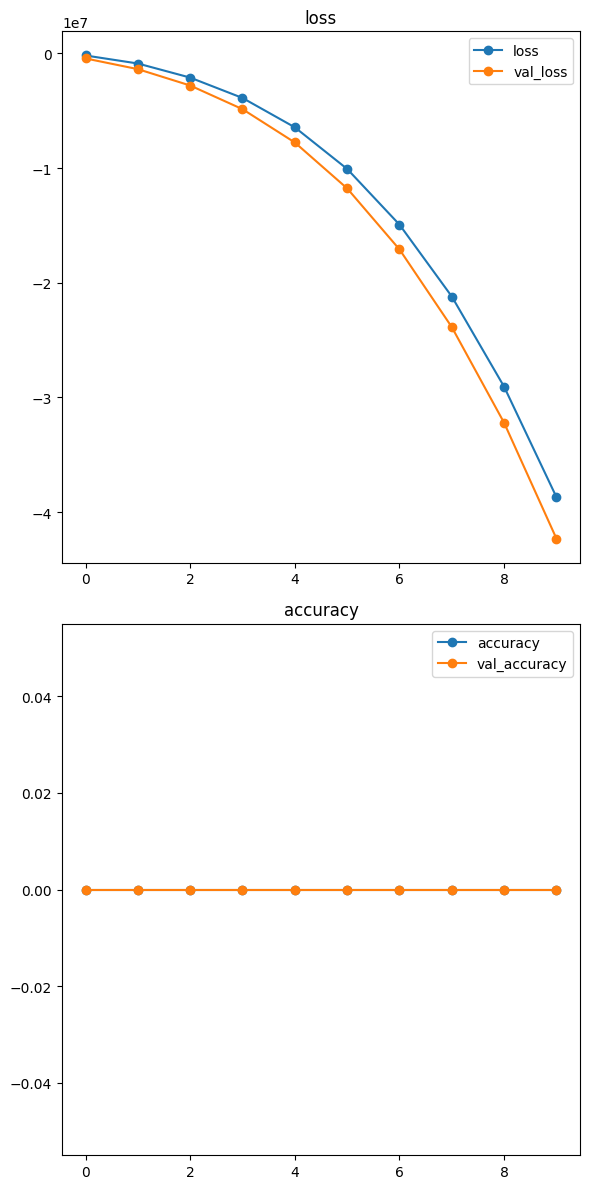

In [128]:
plot_history(history);

In [ ]:
# Evaluate neural network with builtin evaluation
result = model2.evaluate(X_test_processed, y_test,return_dict=True)
result

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       0.0
     40000.0       0.00      0.00      0.00       1.0
     52500.0       0.00      0.00      0.00       1.0
     55000.0       0.00      0.00      0.00       1.0
     58500.0       0.00      0.00      0.00       1.0
     64500.0       0.00      0.00      0.00       1.0
     73000.0       0.00      0.00      0.00       1.0
     75500.0       0.00      0.00      0.00       1.0
     87000.0       0.00      0.00      0.00       1.0
     88000.0       0.00      0.00      0.00       1.0
     93000.0       0.00      0.00      0.00       1.0
     94500.0       0.00      0.00      0.00       1.0
     94750.0       0.00      0.00      0.00       1.0
     95000.0       0.00      0.00      0.00       1.0
     96500.0       0.00      0.00      0.00       2.0
     98000.0       0.00      0.00      0.00       1.0
     99900.0       0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

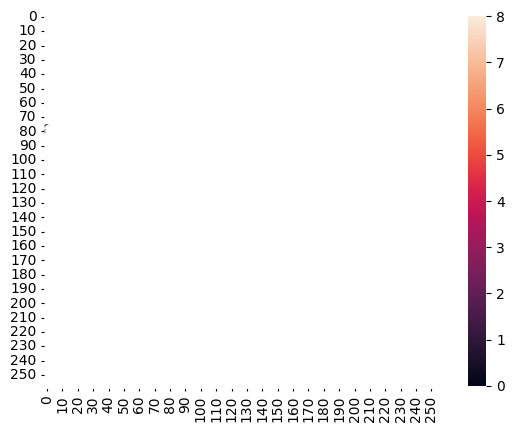

In [129]:
# evaluate the model with sklearn metrics
test_preds = model2.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt = 'g');

# Model 3: More layers

In [130]:
# create model
model3 = keras.Sequential()
model3.add(Dense(20, input_dim=X_train_processed.shape[1],
        activation = 'relu'))
model3.add(Dense(5, activation = 'relu'))
model3.add(Dense(5, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))

model3.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

In [131]:
# train the model and save the history
history = model3.fit(X_train_processed, y_train,
          validation_split = .2,
          epochs = 10)

Epoch 1/10
28/28 [==============================] - 1s 10ms/step - loss: 742.9763 - accuracy: 0.0000e+00 - val_loss: -4806.6953 - val_accuracy: 0.0000e+00
Epoch 2/10
28/28 [==============================] - 0s 4ms/step - loss: -7492.7939 - accuracy: 0.0000e+00 - val_loss: -10068.1396 - val_accuracy: 0.0000e+00
Epoch 3/10
28/28 [==============================] - 0s 4ms/step - loss: -15385.6084 - accuracy: 0.0000e+00 - val_loss: -31703.4863 - val_accuracy: 0.0000e+00
Epoch 4/10
28/28 [==============================] - 0s 4ms/step - loss: -86212.9766 - accuracy: 0.0000e+00 - val_loss: -191180.4375 - val_accuracy: 0.0000e+00
Epoch 5/10
28/28 [==============================] - 0s 3ms/step - loss: -399023.8125 - accuracy: 0.0000e+00 - val_loss: -666685.8125 - val_accuracy: 0.0000e+00
Epoch 6/10
28/28 [==============================] - 0s 4ms/step - loss: -1094343.0000 - accuracy: 0.0000e+00 - val_loss: -1586144.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
28/28 [==============================]

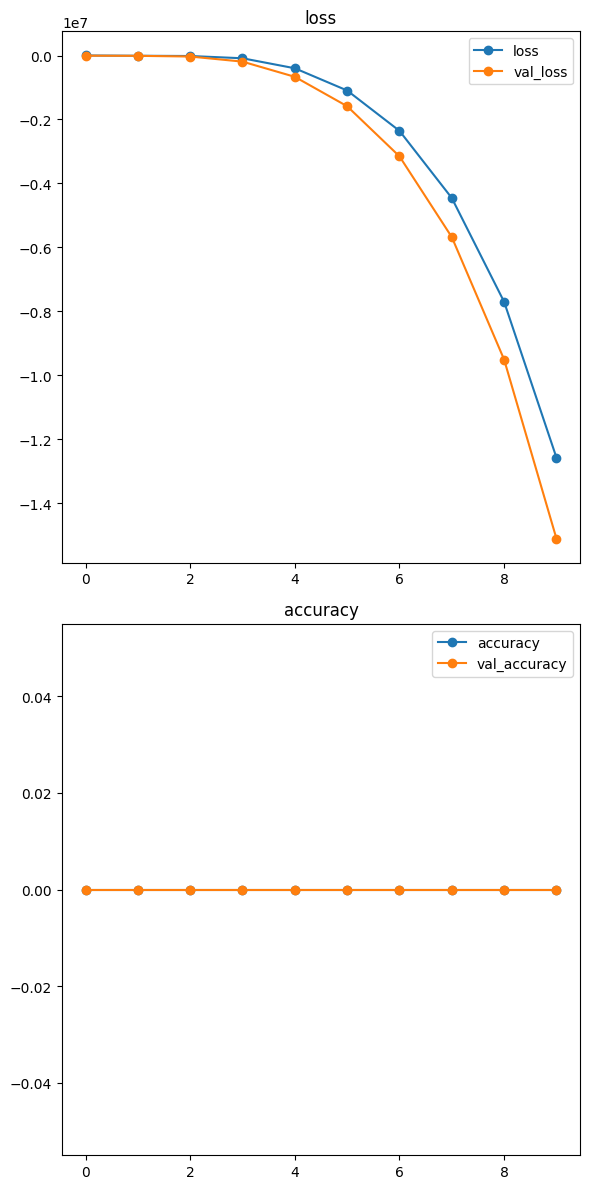

In [132]:
# Obtain history
plot_history(history);

In [133]:
# Evaluate neural network with builtin evaluation
result = model3.evaluate(X_test_processed, y_test,return_dict=True)
result

12/12 [==============================] - 0s 2ms/step - loss: -15269282.0000 - accuracy: 0.0000e+00


{'loss': -15269282.0, 'accuracy': 0.0}

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       0.0
     40000.0       0.00      0.00      0.00       1.0
     52500.0       0.00      0.00      0.00       1.0
     55000.0       0.00      0.00      0.00       1.0
     58500.0       0.00      0.00      0.00       1.0
     64500.0       0.00      0.00      0.00       1.0
     73000.0       0.00      0.00      0.00       1.0
     75500.0       0.00      0.00      0.00       1.0
     87000.0       0.00      0.00      0.00       1.0
     88000.0       0.00      0.00      0.00       1.0
     93000.0       0.00      0.00      0.00       1.0
     94500.0       0.00      0.00      0.00       1.0
     94750.0       0.00      0.00      0.00       1.0
     95000.0       0.00      0.00      0.00       1.0
     96500.0       0.00      0.00      0.00       2.0
     98000.0       0.00      0.00      0.00       1.0
     99900.0       0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

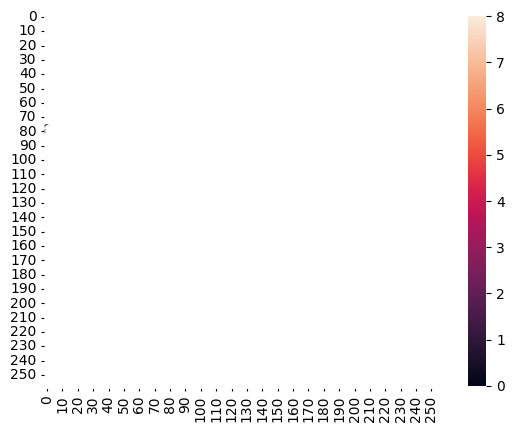

In [134]:
# evaluate the model
test_preds = model3.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt ='g');